In [1]:
import os
import sys

import itertools
import pickle
import imageio
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

sys.path.append('../')
import utils
%matplotlib inline

In [2]:
root_folder = 'MNIST_FADER_results'
fixed_folder = root_folder + '/Fixed_results'

if not os.path.isdir(root_folder):
    os.mkdir(root_folder)
if not os.path.isdir(fixed_folder):
    os.mkdir(fixed_folder)

In [3]:
lr = 0.001
latent_size = 10
batch_size = 256
train_epoch = 1000

In [4]:
normalize = ((0.5,), (0.5,))
train_loader = utils.loader(batch_size=batch_size, train=True, normalize=normalize, path='../dataset')
test_loader = utils.loader(batch_size=batch_size, train=False, normalize=normalize, path='../dataset')

In [5]:
fixed_indxs = [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
fixed_x = torch.cat([test_loader.dataset[i][0] for i in fixed_indxs], 0).view(-1, 784)
fixed_x = Variable(fixed_x.repeat(1, 10).view(-1, 784), volatile=True)
fixed_y = Variable(torch.eye(10).repeat(10, 1), volatile=True)

In [6]:
def show_result(num_epoch, latent_size, show=False, save=False, path='result.png'):
    E.eval()
    G.eval()
    test_images = G(E(fixed_x), fixed_y)
    E.train()
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(10, 10))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    
    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        

def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    x = range(len(hist['R_losses']))

    y1 = hist['R_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='R_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [7]:
class encoder(nn.Module):
    def __init__(self, output_size=10):
        super(encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, output_size)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return x

In [8]:
class generator(nn.Module):
    def __init__(self, input_size=10,):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size + 10, 128)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 28*28)

    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.tanh(self.fc3(x))
        
        return x

In [9]:
class regressor(nn.Module):
    def __init__(self, input_size=10):
        super(regressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.dropout(x, 0.3)
        x = F.tanh(self.fc2(x))
        x = F.dropout(x, 0.3)
        x = F.log_softmax(self.fc3(x), 1)

        return x

In [10]:
# networks
E = encoder(output_size=latent_size)
G = generator(input_size=latent_size)
R = regressor(input_size=latent_size)

# losses
MSE_loss = nn.MSELoss()
NLL_loss = nn.NLLLoss()

# optimizers
E_optimizer = optim.Adam(E.parameters(), lr=lr)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
R_optimizer = optim.Adam(R.parameters(), lr=lr)

[1/1000]: loss_r: 2.311, loss_ae: 0.237, loss_e: 2.305


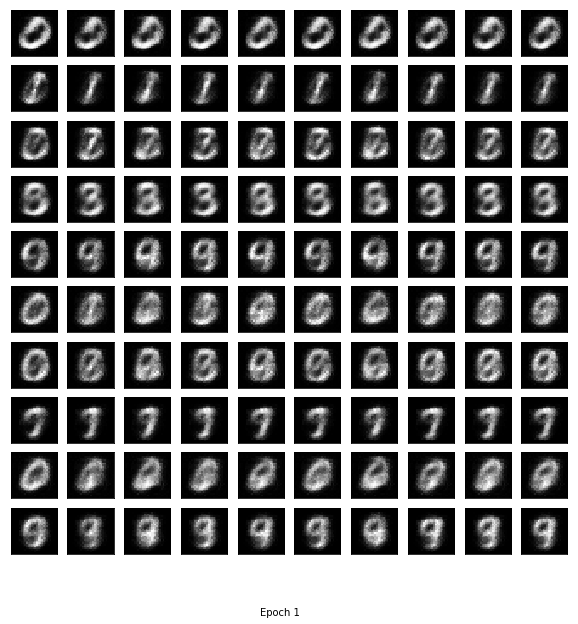

[2/1000]: loss_r: 2.316, loss_ae: 0.193, loss_e: 2.305


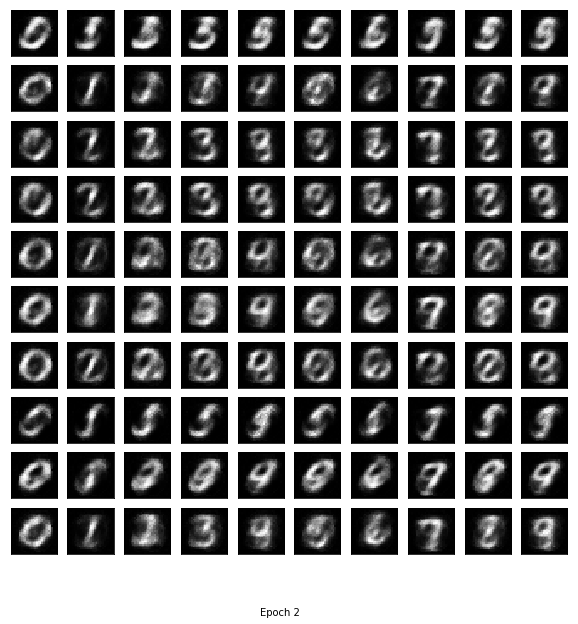

[3/1000]: loss_r: 2.305, loss_ae: 0.166, loss_e: 2.298


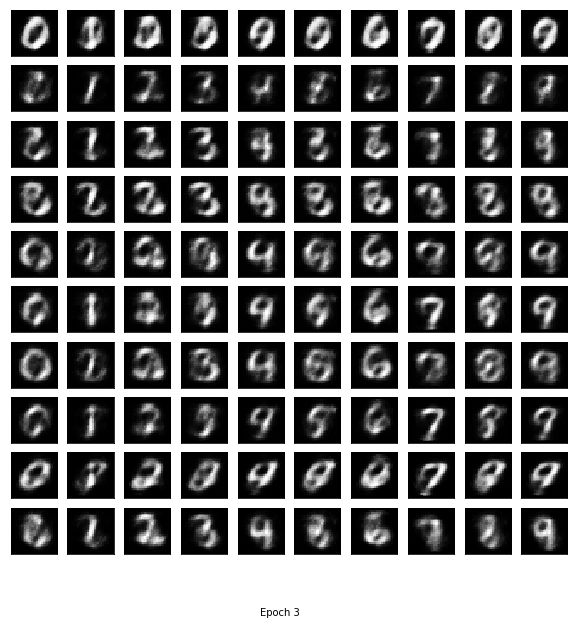

[4/1000]: loss_r: 2.308, loss_ae: 0.150, loss_e: 2.301


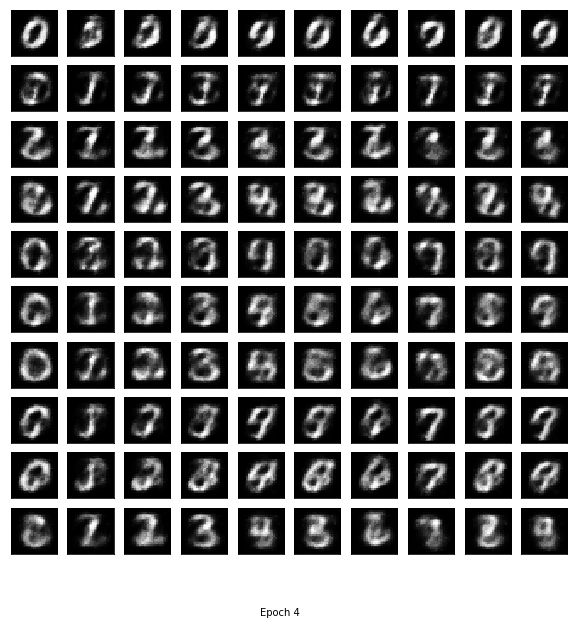

KeyboardInterrupt: 

In [11]:
train_hist = {}
train_hist['R_losses'] = []
train_hist['G_losses'] = []
train_hist['E_losses'] = []

for epoch in range(train_epoch):
    E_losses = []
    R_losses = []
    G_losses = []
    for x, y in train_loader:
        # train regressor R
        mini_batch = x.size()[0]

        x = x.view(-1, 28 * 28)
        y_onehot = utils.to_onehot(y, 10)
        
        E.zero_grad()
        R.zero_grad()
        G.zero_grad()

        x, y = Variable(x), Variable(y)
        
        z_encoded = E(x)
        
        R_loss = NLL_loss(R(z_encoded), y)

        R_loss.backward(retain_graph=True)
        R_optimizer.step()

        R_losses.append(R_loss.data[0])
        
        # train generator G and encoder E
        E.zero_grad()
        R.zero_grad()
        G.zero_grad()
        
        AE_loss = MSE_loss(G(z_encoded, y_onehot), x)
        R_loss = NLL_loss(R(z_encoded), y)
    
        FADER_loss = AE_loss - R_loss

        FADER_loss.backward()
        G_optimizer.step()
        E_optimizer.step()
        G_losses.append(AE_loss.data[0])
        E_losses.append(R_loss.data[0])
        
    E_loss_mean = torch.mean(torch.FloatTensor(E_losses))
    G_loss_mean = torch.mean(torch.FloatTensor(G_losses))
    R_loss_mean = torch.mean(torch.FloatTensor(R_losses))
    print('[%d/%d]: loss_r: %.3f, loss_ae: %.3f, loss_e: %.3f' % (
        (epoch + 1), train_epoch, R_loss_mean, G_loss_mean, E_loss_mean))
    
    fixed_p = fixed_folder + '/MNIST_FADER_%03d.png' % (epoch+1)
    show_result((epoch+1), latent_size=latent_size, save=True, show=True, path=fixed_p)
    train_hist['R_losses'].append(R_loss_mean)
    train_hist['G_losses'].append(G_loss_mean)
    train_hist['E_losses'].append(E_loss_mean)
    
print("Training finish!... save training results")
torch.save(G.state_dict(), root_folder + '/generator_param.pkl')
torch.save(R.state_dict(), root_folder + '/regressor_param.pkl')
torch.save(E.state_dict(), root_folder + '/encoder_param.pkl')